### Install KIAUHOKU, if you haven't done so already. 

In [1]:
#!pip install git+https://github.com/zclaytor/kiauhoku@v2.1.1

In [2]:
import kiauhoku as kh
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

## This notebook serves as a demonstration on how to estimate the theoretical uncertainites due to model choice for stars along the red giant branch. 

### Load grids, unify column names, and cast to interpolators

In [3]:
qstring = '0.6 <= initial_mass <= 2 and -1.0 <= initial_met <= 0.5 and 201 <= eep <= 951' 
qstringm = '0.6 <= initial_mass <= 2 and -1.0 <= initial_met <= 0.5 and 201 <= eep <= 605'

# Whether to fit evolved metallicity (True) or use the initial metallicity.
# False is probably fine if you're not on the giant branch.
evolve_met = False

yrec = kh.load_eep_grid("yrec").query(qstring)
# set column names to some standard
yrec['mass'] = yrec['Mass(Msun)']
yrec['teff'] = 10**yrec['Log Teff(K)']
yrec['lum'] = 10**yrec['L/Lsun']
if evolve_met:
    yrec['met'] = np.log10(yrec['Zsurf']/yrec['Xsurf']/0.0253)
else:
    yrec['met'] = yrec.index.get_level_values('initial_met')
yrec['age'] = yrec['Age(Gyr)']
# set name for readability of output
yrec.set_name('yrec')
# cast to interpolator
yrec = yrec.to_interpolator()

mist = kh.load_eep_grid("mist").query(qstringm)
mist['mass'] = mist['star_mass']
mist['teff'] = 10**mist['log_Teff']
mist['lum'] = 10**mist['log_L']
if evolve_met:
    mist['met'] = mist['log_surf_z'] - np.log10(mist['surface_h1']*0.0173)
else:
    mist['met'] = mist.index.get_level_values('initial_met')
mist['logg'] = mist['log_g']
mist['age'] = mist['star_age'] / 1e9
mist.set_name('mist')
mist = mist.to_interpolator()

dart = kh.load_eep_grid("dartmouth").query(qstring)
dart['mass'] = dart.index.to_frame()['initial_mass']
dart['teff'] = 10**dart['Log T']
dart['lum'] = 10**dart['Log L']
if evolve_met:
    dart['met'] = np.log10(dart['(Z/X)_surf']/0.0229)
else:
    dart['met'] = dart.index.get_level_values('initial_met')
dart['logg'] = dart['Log g']
dart['age'] = dart['Age (yrs)'] / 1e9
dart.set_name('dart')
dart = dart.to_interpolator()

gars = kh.load_eep_grid("garstec").query(qstring)
gars['mass'] = gars['M/Msun']
gars['teff'] = gars['Teff']
gars['lum'] = 10**gars['Log L/Lsun']
if evolve_met:
    gars['met'] = np.log10(gars['Zsurf']/gars['Xsurf']/0.0245)
else:
    gars['met'] = gars.index.get_level_values('initial_met')
gars['age'] = gars['Age(Myr)'] / 1e3
gars.set_name('gars')
gars = gars.to_interpolator()

### Define a function to get information on your stars from the grids

In [4]:
def fit_all_grids(star, *args, **kwargs):
    gridnames = []
    models = []
    for gname, interp in zip(
        ['yrec', 'mist', 'dartmouth', 'garstec'],
        [yrec, mist, dart, gars]):
        model, fit = interp.gridsearch_fit(star, *args, **kwargs)
        if fit.success:
            gridnames.append(gname)
            models.append(
                model[['initial_mass', 'initial_met', 'eep', 'mass', 'teff', 'lum', 'met', 'logg', 'age']]
            )
    models = pd.concat(models, axis=1)
    models.columns = gridnames

    return models

### Sample of stars from the APOKASC-3 catalogue

*Note*: The full catalog can be found here: https://zenodo.org/records/13308665 

In [5]:
columns = [
    "KEPLER_ID","APOKASC3_MASS", "APOKASC3_MASS_ERR", "APOKASC3_RADIUS", "APOKASC3_RADIUS_ERR", "APOKASC3_LOGG", 
    "APOKASC3_LOGG_ERR", "APOKASC3_TEFF", "APOKASC3_TEFF_ERR", "APOKASC3_LOGG_SPEC", 
    "APOKASC3_LOGG_SPEC_ERR", "APOKASC3_M_H", "APOKASC3_M_H_ERR", "APOKASC3_ALPHA_M", 
    "APOKASC3_ALPHA_M_ERR", "APOKASC3_CAT_AGE", "APOKASC3_AGE_RGB", "APOKASC3_AGE_RGB_PERR", 
    "APOKASC3_AGE_RGB_MERR", "GAIA_TEFF", "GAIA_RADIUS", "GAIA_LUMINOSITY"
]

stars = [
    [10001440, 0.9482, 0.0365, 8.5217, 0.1475, 2.5553, 0.0042, 4750.2197, 52.0059, 2.4996, 0.058, -0.6552, 0.058, 0.3028, 0.022, "RGB", 10.0665, 1.5825, -1.2631, 4977.75, 7.628748, 32.190933],
    [10003349, 1.3773, 0.0531, 9.8369, 0.1705, 2.5931, 0.004, 4671.34, 46.7252, 2.6277, 0.058, -0.0492, 0.058, 0.0279, 0.022, "RGB", 3.7948, 0.4298, -0.3323, 4694.6104, 10.917146, 52.15682],
    [10003497, 1.1867, 0.0458, 12.1523, 0.2108, 2.3408, 0.0038, 4615.7476, 42.5666, 2.4042, 0.058, -0.1903, 0.058, 0.0743, 0.022, "RGB", 5.6234, 0.683, -0.5678, 4720.2524, 10.944278, 53.571007],
    [10004825, 1.688, 0.0651, 10.0175, 0.1737, 2.6656, 0.0041, 4653.666, 47.6694, 2.7126, 0.058, 0.181, 0.058, 0.0257, 0.022, "RGB", 2.2867, 0.2219, -0.1879, 4806.7476, 9.497579, 43.383617],
    [10006097, 1.099, 0.0422, 5.1385, 0.0889, 3.0591, 0.0041, 4795.506, 49.7726, 3.0803, 0.058, -0.0276, 0.058, 0.0554, 0.022, "RGB", 8.1643, 1.1403, -0.9563, 5004.34, 4.5984993, 11.94852]
]

star_data = pd.DataFrame(stars,columns=columns)
star_data

,KEPLER_ID,APOKASC3_MASS,APOKASC3_MASS_ERR,APOKASC3_RADIUS,APOKASC3_RADIUS_ERR,APOKASC3_LOGG,APOKASC3_LOGG_ERR,APOKASC3_TEFF,APOKASC3_TEFF_ERR,APOKASC3_LOGG_SPEC,...,APOKASC3_M_H_ERR,APOKASC3_ALPHA_M,APOKASC3_ALPHA_M_ERR,APOKASC3_CAT_AGE,APOKASC3_AGE_RGB,APOKASC3_AGE_RGB_PERR,APOKASC3_AGE_RGB_MERR,GAIA_TEFF,GAIA_RADIUS,GAIA_LUMINOSITY
0,10001440,0.9482,0.0365,8.5217,0.1475,2.5553,0.0042,4750.2197,52.0059,2.4996,...,0.058,0.3028,0.022,RGB,10.0665,1.5825,-1.2631,4977.7500,7.628748,32.190933
1,10003349,1.3773,0.0531,9.8369,0.1705,2.5931,0.0040,4671.3400,46.7252,2.6277,...,0.058,0.0279,0.022,RGB,3.7948,0.4298,-0.3323,4694.6104,10.917146,52.156820
2,10003497,1.1867,0.0458,12.1523,0.2108,2.3408,0.0038,4615.7476,42.5666,2.4042,...,0.058,0.0743,0.022,RGB,5.6234,0.6830,-0.5678,4720.2524,10.944278,53.571007
3,10004825,1.6880,0.0651,10.0175,0.1737,2.6656,0.0041,4653.6660,47.6694,2.7126,...,0.058,0.0257,0.022,RGB,2.2867,0.2219,-0.1879,4806.7476,9.497579,43.383617
4,10006097,1.0990,0.0422,5.1385,0.0889,3.0591,0.0041,4795.5060,49.7726,3.0803,...,0.058,0.0554,0.022,RGB,8.1643,1.1403,-0.9563,5004.3400,4.598499,11.948520


In [6]:
# Apply Salaris correction 
# All methods will use this metallicity 
met_corr = star_data['APOKASC3_M_H'] + np.log10(0.638*(10**star_data['APOKASC3_ALPHA_M']) + 0.362)

#Asteroseismic params
mass = star_data['APOKASC3_MASS']
logg = star_data['APOKASC3_LOGG']

#Spectroscopic params
logg_spec = star_data['APOKASC3_LOGG_SPEC']
teff = star_data['APOKASC3_TEFF']

#Photometric params
lum = star_data['GAIA_LUMINOSITY']
teff_gaia = star_data['GAIA_TEFF']

### Let's start with the first star on the list

In [7]:
#Using asteroseismic params
params = {'mass':mass[0],'met':met_corr[0],'logg':logg[0]}

models_0a = fit_all_grids(params,scale=(1, 1, 1), tol=1e-6)
models_0a

Fitting star with yrec...
yrec: success!
Fitting star with mist...
mist: success!
Fitting star with dart...
dart: success!
Fitting star with gars...
gars: success!


,yrec,mist,dartmouth,garstec
initial_mass,0.948200,0.949807,0.948199,0.952378
initial_met,-0.439507,-0.439507,-0.439507,-0.439507
eep,536.214374,515.314692,537.241556,538.022909
mass,0.948200,0.948201,0.948199,0.948200
teff,4746.247187,4729.186402,4772.317132,4800.954203
lum,32.979293,32.648429,33.797674,34.603380
met,-0.439507,-0.439507,-0.439507,-0.439507
logg,2.555300,2.555299,2.555301,2.555300
age,11.020405,9.680621,10.377827,10.655114


In [8]:
#Using spectroscopic params
params = {'logg':logg_spec[0],'met':met_corr[0],'teff':teff[0]}

models_0b = fit_all_grids(params,scale=(1, 1, 1000), tol=1e-6)
models_0b

Fitting star with yrec...
yrec: success!
Fitting star with mist...
mist: success!
Fitting star with dart...
dart: success!
Fitting star with gars...
gars: success!


,yrec,mist,dartmouth,garstec
initial_mass,1.087384,1.178919,0.960727,0.825657
initial_met,-0.439507,-0.439506,-0.439507,-0.439506
eep,547.877070,519.004709,542.295398,540.032760
mass,1.087384,1.177247,0.960727,0.823697
teff,4750.219616,4750.219277,4750.219416,4750.219874
lum,43.282081,46.886837,38.207937,32.707921
met,-0.439507,-0.439506,-0.439507,-0.439506
logg,2.499600,2.499599,2.499600,2.499599
age,6.622052,4.533941,9.935409,17.509672


In [9]:
#Using photometric params
params = {'lum':lum[0],'met':met_corr[0],'teff':teff_gaia[0]}

models_0c = fit_all_grids(params,scale=(1, 1, 1000), tol=1e-6)
models_0c

Fitting star with yrec...
yrec: success!
Fitting star with mist...
mist: success!
Fitting star with dart...
dart: success!
Fitting star with gars...
gars: success!


,yrec,mist,dartmouth,garstec
initial_mass,1.432457,1.514693,1.410079,1.314526
initial_met,-0.439507,-0.439503,-0.439507,-0.439837
eep,534.659377,511.749509,535.113968,533.610767
mass,1.432457,1.513565,1.410079,1.311912
teff,4977.750583,4977.748592,4977.751924,4977.533064
lum,32.190934,32.190931,32.190931,32.190928
met,-0.439507,-0.439503,-0.439507,-0.439837
logg,2.827399,2.853163,2.820472,2.789120
age,2.551556,1.937777,2.656574,3.373528


### Next, we are going to find the max fractional offset between the model grids. 

In [10]:
#What is the offset for the case with known mass?
offset_0a = (max(models_0a.loc['age']) - min(models_0a.loc['age'])) / max(models_0a.loc['age']) * 100 
print(f"Fractional offset between model grids: {offset_0a:0.1f}%")

Fractional offset between model grids: 12.2%


In [11]:
#What is the offset for the cases WITHOUT known mass?
offset_0b = (max(models_0b.loc['age']) - min(models_0b.loc['age'])) / max(models_0b.loc['age']) * 100 
offset_0c = (max(models_0c.loc['age']) - min(models_0c.loc['age'])) / max(models_0c.loc['age']) * 100
print(f"Fractional offset between model grids: \nUsing spectroscopic surface gravity and effective temperature: {offset_0b:0.1f}%")
print(f"Using GAIA luminosity and effective temperature: {offset_0c:0.1f}%")

Fractional offset between model grids: 
Using spectroscopic surface gravity and effective temperature: 74.1%
Using GAIA luminosity and effective temperature: 42.6%


### Let's try the last giant on the list

In [12]:
#Using asteroseismic params
params = {'mass':mass[4],'met':met_corr[4],'logg':logg[4]}

models_4a = fit_all_grids(params,scale=(1, 1, 1), tol=1e-6)
models_4a

Fitting star with yrec...
yrec: success!
Fitting star with mist...
mist: success!
Fitting star with dart...
dart: success!
Fitting star with gars...
gars: success!


,yrec,mist,dartmouth,garstec
initial_mass,1.098999,1.100004,1.099000,1.102671
initial_met,0.008551,0.008551,0.008554,0.008550
eep,508.171331,497.852067,508.022444,508.724368
mass,1.098999,1.099000,1.099000,1.099001
teff,4794.494171,4740.862198,4760.795337,4833.682269
lum,12.479965,11.974492,12.132903,12.895775
met,0.008551,0.008551,0.008554,0.008550
logg,3.059099,3.059101,3.059100,3.059102
age,8.546185,7.917061,8.498286,8.377099


In [13]:
#Using spectroscopic params
params = {'logg':logg_spec[4],'met':met_corr[4],'teff':teff[4]}

models_4b = fit_all_grids(params,scale=(1, 1, 1000), tol=1e-6)
models_4b

Fitting star with yrec...
yrec: success!
Fitting star with mist...
mist: success!
Fitting star with dart...
dart: success!
Fitting star with gars...
gars: success!


,yrec,mist,dartmouth,garstec
initial_mass,1.078179,1.276864,1.219311,0.975325
initial_met,0.008551,0.008551,0.008552,0.008551
eep,507.181705,497.583393,509.401692,505.452477
mass,1.078179,1.275841,1.219311,0.974238
teff,4795.506500,4795.505746,4795.506659,4795.506179
lum,11.661892,13.885527,13.205063,10.548554
met,0.008551,0.008551,0.008552,0.008551
logg,3.080301,3.080300,3.080300,3.080300
age,9.308633,4.665100,5.739830,13.196535


In [14]:
#Using photometric params
params = {'lum':lum[4],'met':met_corr[4],'teff':teff_gaia[4]}

models_4c = fit_all_grids(params,scale=(1, 1, 1000), tol=1e-6)
models_4c

Fitting star with yrec...
yrec: success!
Fitting star with mist...
mist: success!
Fitting star with dart...
dart: success!
Fitting star with gars...
gars: success!


,yrec,mist,dartmouth,garstec
initial_mass,1.541945,1.658073,1.596995,1.457282
initial_met,0.008538,0.008550,0.008538,0.008568
eep,508.097026,487.870192,507.919907,508.498199
mass,1.541945,1.657162,1.596995,1.456107
teff,5004.346232,5004.339724,5004.348276,5004.346006
lum,11.948510,11.948519,11.948507,11.948514
met,0.008538,0.008550,0.008538,0.008568
logg,3.299234,3.332299,3.314787,3.274636
age,2.564132,1.859316,2.320299,3.093366


In [15]:
#What is the offset for the case with known mass?
offset_4a = (max(models_4a.loc['age']) - min(models_4a.loc['age'])) / max(models_4a.loc['age']) * 100 
print(f"Fractional offset between model grids: {offset_4a:0.1f}%")

Fractional offset between model grids: 7.4%


In [16]:
#What is the offset for the cases WITHOUT known mass?
offset_4b = (max(models_4b.loc['age']) - min(models_4b.loc['age'])) / max(models_4b.loc['age']) * 100 
offset_4c = (max(models_4c.loc['age']) - min(models_4c.loc['age'])) / max(models_4c.loc['age']) * 100
print(f"Fractional offset between model grids: \nUsing spectroscopic surface gravity and effective temperature: {offset_4b:0.1f}%")
print(f"Using GAIA luminosity and effective temperature: {offset_4c:0.1f}%")

Fractional offset between model grids: 
Using spectroscopic surface gravity and effective temperature: 64.6%
Using GAIA luminosity and effective temperature: 39.9%


### Let's plot some tracks to check the interpolation of the first star on the list for the cases without known mass

#### We want to ensure that the grid estimated mass aligns with the model tracks. 

Grid estimated mass (Msun): 
yrec         1.087384
mist         1.177247
dartmouth    0.960727
garstec      0.823697
Name: mass, dtype: float64


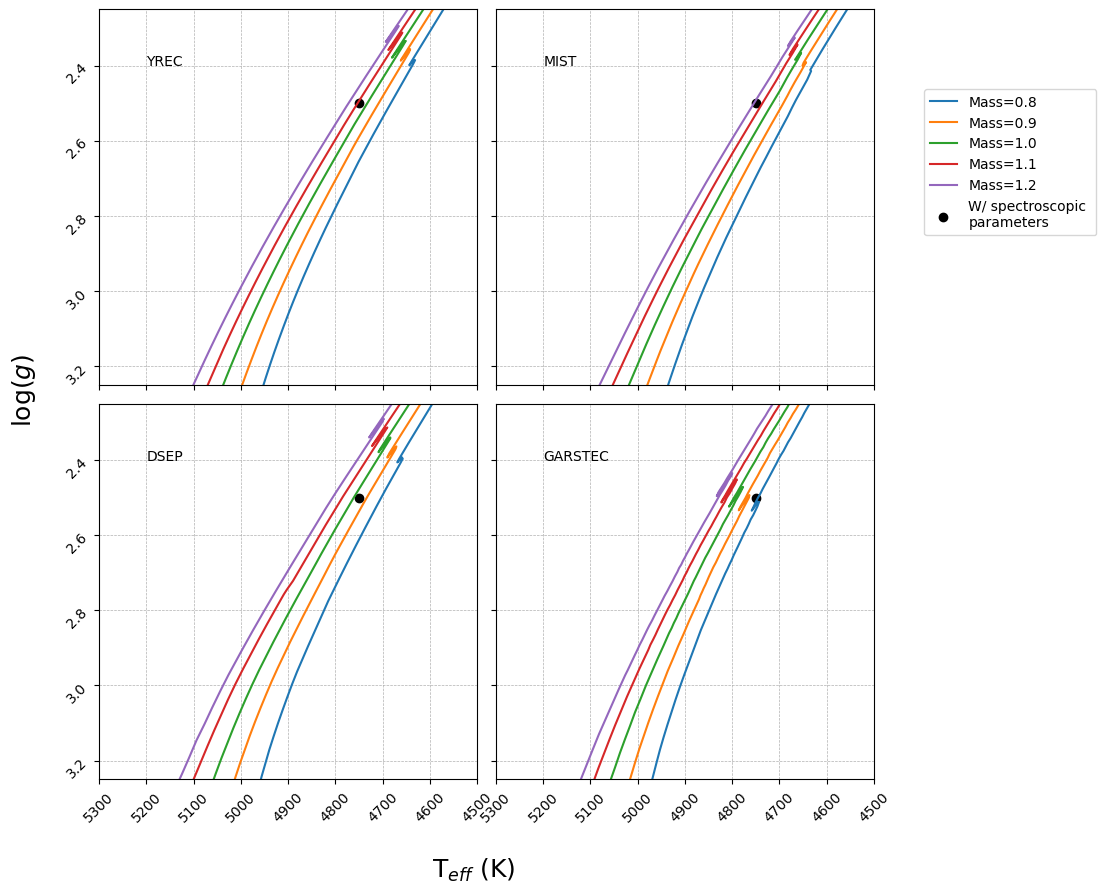

In [17]:
def get_tracks(model, masses, metallicity=0.0):
    return [model.get_track((mass, metallicity)) for mass in masses]

models = {"YREC": yrec, "MIST": mist, "DSEP": dart, "GARS": gars}
masses = [0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6]
metallicity = met_corr[0]

yrec_tracks = get_tracks(yrec, masses, metallicity=metallicity)
mist_tracks = get_tracks(mist, masses, metallicity=metallicity)
dart_tracks = get_tracks(dart, masses, metallicity=metallicity) 
gars_tracks = get_tracks(gars, masses, metallicity=metallicity)


fig,arr = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)
for mass, track in zip(masses[0:5], yrec_tracks[0:5]):
    arr[0, 0].plot(track['teff'], track['logg'], label=f"Mass={mass:.1f}")
for mass, track in zip(masses[0:5], mist_tracks[0:5]):
    arr[0, 1].plot(track['teff'], track['logg'])
for mass, track in zip(masses[0:5], dart_tracks[0:5]):
    arr[1, 0].plot(track['teff'], track['logg'])
for mass, track in zip(masses[0:5], gars_tracks[0:5]):
    arr[1, 1].plot(track['teff'], track['logg'])

arr[0, 0].annotate('YREC',xy=(5200,2.4),xytext=(5200,2.4),size='medium')
arr[0, 1].annotate('MIST',xy=(5200,2.4),xytext=(5200,2.4),size='medium')
arr[1, 0].annotate('DSEP',xy=(5200,2.4),xytext=(5200,2.4),size='medium')
arr[1, 1].annotate('GARSTEC',xy=(5200,2.4),xytext=(5200,2.4),size='medium')

arr[0,0].invert_xaxis()
arr[0,0].set_ylim(3.25,2.25)
arr[0,0].set_xlim(5300,4500)

for i in range(2):
    for j in range(2): 
        arr[i, j].grid(True, which='both', linestyle='--', linewidth=0.5)
        arr[i, j].tick_params(axis='x', rotation=45)
        arr[i, j].tick_params(axis='y', rotation=45)
        arr[i, j].tick_params(axis='both', labelsize=10)

#plot the star
arr[0,0].scatter(models_0b['yrec'].loc['teff'],models_0b['yrec'].loc['logg'],c='k',label='W/ spectroscopic \nparameters')
arr[0,1].scatter(models_0b['mist'].loc['teff'],models_0b['mist'].loc['logg'],c='k')
arr[1,0].scatter(models_0b['dartmouth'].loc['teff'],models_0b['dartmouth'].loc['logg'],c='k')
arr[1,1].scatter(models_0b['garstec'].loc['teff'],models_0b['garstec'].loc['logg'],c='k')

fig.text(0.05, 0.5, r'$\log(g)$', ha='center', va='center', rotation='vertical',size=18)
fig.text(0.5, 0.02, r'T$_{eff}$ (K)', ha='center', va='center',size=18)
fig.legend(bbox_to_anchor=(0.95, 0.8), loc='upper left', borderaxespad=0.)
plt.subplots_adjust(hspace=0.05,wspace=0.05);
print(f"Grid estimated mass (Msun): \n{models_0b.loc['mass']}")

#### Now, let's check the interpolation using photometric parameters. 

Grid estimated mass (Msun): 
yrec         1.432457
mist         1.513565
dartmouth    1.410079
garstec      1.311912
Name: mass, dtype: float64


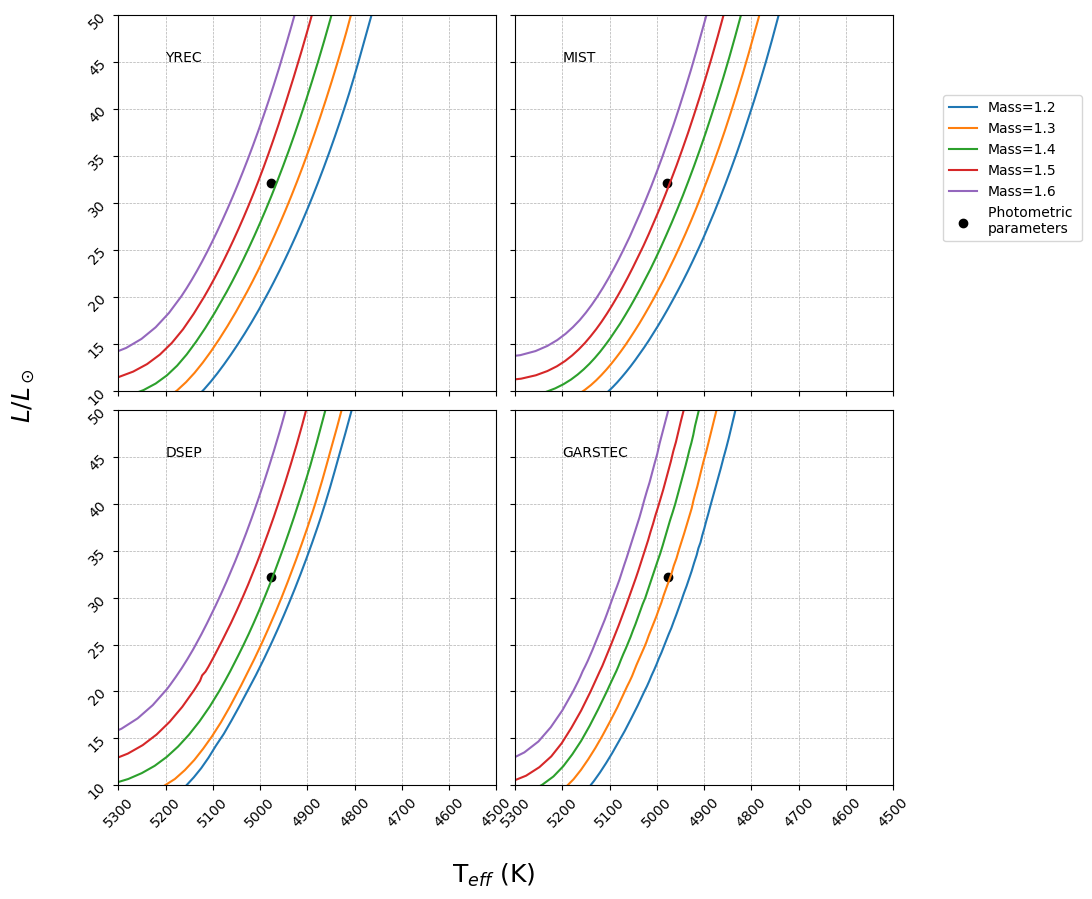

In [18]:
fig,arr = plt.subplots(2,2,figsize=(10,10),sharex=True,sharey=True)
for mass, track in zip(masses[4:9], yrec_tracks[4:9]):
    arr[0, 0].plot(track['teff'], track['lum'], label=f"Mass={mass:.1f}")
for mass, track in zip(masses[4:9], mist_tracks[4:9]):
    arr[0, 1].plot(track['teff'], track['lum'])
for mass, track in zip(masses[4:9], dart_tracks[4:9]):
    arr[1, 0].plot(track['teff'], track['lum'])
for mass, track in zip(masses[4:9], gars_tracks[4:9]):
    arr[1, 1].plot(track['teff'], track['lum'])

arr[0, 0].annotate('YREC',xy=(5200,45),xytext=(5200,45),size='medium')
arr[0, 1].annotate('MIST',xy=(5200,45),xytext=(5200,45),size='medium')
arr[1, 0].annotate('DSEP',xy=(5200,45),xytext=(5200,45),size='medium')
arr[1, 1].annotate('GARSTEC',xy=(5200,45),xytext=(5200,45),size='medium')

arr[0,0].invert_xaxis()
arr[0,0].set_ylim(10,50)
arr[0,0].set_xlim(5300,4500)

for i in range(2):
    for j in range(2): 
        arr[i, j].grid(True, which='both', linestyle='--', linewidth=0.5)
        arr[i, j].tick_params(axis='x', rotation=45)
        arr[i, j].tick_params(axis='y', rotation=45)
        arr[i, j].tick_params(axis='both', labelsize=10)


arr[0,0].scatter(models_0c['yrec'].loc['teff'],models_0c['yrec'].loc['lum'],c='k',label='Photometric \nparameters')
arr[0,1].scatter(models_0c['mist'].loc['teff'],models_0c['mist'].loc['lum'],c='k')
arr[1,0].scatter(models_0c['dartmouth'].loc['teff'],models_0c['dartmouth'].loc['lum'],c='k')
arr[1,1].scatter(models_0c['garstec'].loc['teff'],models_0c['garstec'].loc['lum'],c='k')

fig.text(0.03, 0.5, r'$L/L_\odot$', ha='center', va='center', rotation='vertical',size=18)
fig.text(0.5, 0.02, r'T$_{eff}$ (K)', ha='center', va='center',size=18)
fig.legend(bbox_to_anchor=(0.95, 0.8), loc='upper left', borderaxespad=0.)
plt.subplots_adjust(hspace=0.05,wspace=0.05);
print(f"Grid estimated mass (Msun): \n{models_0c.loc['mass']}")

### Good news is that our interpolation process works! :D 
### Bad news is that we are left with a hefty offset in age between grids when mass is unknown. :(